In [ ]:
!pip install pettingzoo --quiet
!pip install tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 20.9 MB/s eta 0:00:00


In [ ]:
import functools

import gymnasium
import numpy as np
from gymnasium.spaces import Discrete, Box
from gymnasium.utils import seeding
from pettingzoo import ParallelEnv
from pettingzoo.utils import wrappers
from pettingzoo.utils.agent_selector import agent_selector
import random
import matplotlib.pyplot as plt

In [ ]:
class PredatorPreyEnv(ParallelEnv):
    metadata = {"name":"predator_prey_v0"}

    def __init__(self,grid_size=10,max_steps=100):
        super().__init__()
        self.grid_size = grid_size
        self.max_steps = max_steps
        self.possible_agents = ["predator_0","predator_1","prey_0"]
        self.agent_name_mapping = dict(zip(self.possible_agents,list(range(len(self.possible_agents)))))
        self._action_spaces = {agent: Discrete(5) for agent in self.possible_agents} #Up, Down, Left, Right, Stay

        obs_space = Box(low=-grid_size,high=grid_size,shape=(10,),dtype=np.float32)#Predators and prey see 6 absolute values [selfx,selfy,predator1x,predator1y,prey0x,prey0y] and 4 relative values
        self.observation_space = {agent: obs_space for agent in self.possible_agents}

        self.steps = 0
        self.agent_positions = {}

    def reset(self,seed=None,options=None):
        self.agents = self.possible_agents[:]
        self.steps = 0

        positions = np.random.choice(self.grid_size*self.grid_size,len(self.agents),replace=False)#Place agents randomly and ensure no overlaps
        for agent,pos_1d in zip(self.agents,positions):
            self.agent_positions[agent] = (pos_1d//self.grid_size,pos_1d%self.grid_size)

        observations = self._get_obs()
        infos = {agent:{} for agent in self.agents}
        return observations,infos

    def _get_obs(self):
        observations = {}

        # for i in range(2): #Predator observation
        #     pred_id = f"predator_{i}"
        #     own_pos = self.agent_positions[pred_id]
        #     other_pred_id = f"predator_{1-i}"
        #     other_pred_pos = self.agent_positions[other_pred_id]
        #     prey_pos = self.agent_positions["prey_0"]

        #     observations[pred_id] = np.array([own_pos[0],own_pos[1],other_pred_pos[0] - own_pos[0],#x,y,x and y distance to other pred and x and y distance to other prey
        #                                       other_pred_pos[1] - own_pos[1],prey_pos[0] - own_pos[0],prey_pos[1] - own_pos[1]],dtype=np.float32)

        #Prey Observation
        prey_pos = np.array(self.agent_positions["prey_0"])
        p0_pos = np.array(self.agent_positions["predator_0"])
        p1_pos = np.array(self.agent_positions["predator_1"])

        # observations["prey_0"] = np.array([prey_pos[0],prey_pos[1],p0_pos[0]-prey_pos[0],p0_pos[1]-prey_pos[1],
        #                                     p1_pos[0]-prey_pos[0],p1_pos[1]-prey_pos[1]],dtype=np.float32)

        observations["predator_0"] = np.concatenate([p0_pos,p1_pos,prey_pos,p1_pos-p0_pos,prey_pos-p0_pos]) #First 6 numbers are absolute positions, the last 4 numbers are relative distances
        observations["predator_1"] = np.concatenate([p1_pos,p0_pos,prey_pos,p0_pos-p1_pos,prey_pos-p1_pos])
        observations["prey_0"] = np.concatenate([prey_pos,p0_pos,p1_pos,p0_pos-prey_pos,p1_pos-prey_pos])

        return observations

    def step(self,actions):
        self.steps += 1

        for agent,action in actions.items():
            x,y = self.agent_positions[agent]
            if action == 0:#Up
                x = max(0,x-1)
            elif action == 1:#Down
                x = min(self.grid_size - 1,x+1)
            elif action == 2:#left
                y = max(0,y-1)
            elif action == 3:
                y = min(self.grid_size-1,y+1)
            self.agent_positions[agent] = (x,y)#Stay
        #Check for terminations (If the prey is caught)
        terminations = {agent: False for agent in self.agents}
        prey_pos = self.agent_positions["prey_0"]
        if prey_pos == self.agent_positions["predator_0"] or prey_pos == self.agent_positions["predator_1"]:
            terminations = {agent: True for agent in self.agents}

        truncations = {agent: self.steps >= self.max_steps for agent in self.agents}#Check for truncations, if max step is reached
        rewards = self._get_rewards(terminations["prey_0"])

        observations = self._get_obs()
        infos = {agent:{} for agent in self.agents}
        if any(terminations.values()) or any (truncations.values()):
            self.agents=[]

        return observations,rewards,terminations,truncations,infos

    def _get_rewards(self,prey_caught):
        rewards = {}
        prey_pos = np.array(self.agent_positions["prey_0"])
        p0_pos = np.array(self.agent_positions["predator_0"])
        p1_pos = np.array(self.agent_positions["predator_1"])

        dist0 = np.linalg.norm(prey_pos-p0_pos)
        dist1 = np.linalg.norm(prey_pos-p1_pos)
        min_dist_to_pred = min(dist0,dist1)

        capture_reward = 100
        survival_reward = 100
        time_penalty = -1

        # if prey_caught: #Old rewards 2: Reward predators for being close to prey, preys for being further from predators. Didn't work as they started farming rewards together
        #     rewards["predator_0"] = 10
        #     rewards["predator_1"] = 10
        #     rewards["prey_0"] = -10
        # else:
        #     #Old rewards 1: predators are penalised the further they are away from prey. Didn't work as prey learned very well but predators failed to learn
        #     # rewards["predator_0"] = -dist0 * 0.1
        #     # rewards["predator_1"] = -dist1 * 0.1
        #     max_dist = 15 #Furthest distance on a 10x10 grid is 12.7 but I use 15 as baseline. The shorter the distance to prey the more reward
        #     rewards["predator_0"] = (max_dist-dist0) * 0.1
        #     rewards["predator_1"] = (max_dist-dist1) * 0.1
        #     rewards["prey_0"] = min_dist_to_pred * 0.1

        if prey_caught: #Predator wins if it captures prey
          rewards["predator_0"] = capture_reward
          rewards["predator_1"] = capture_reward
          rewards["prey_0"] = -capture_reward
        elif self.steps >= self.max_steps: #Prey wins if it survives the full time
          rewards["predator_0"] = -survival_reward
          rewards["predator_1"] = -survival_reward
          rewards["prey_0"] = survival_reward
        else: #Penalise predators for each step, encouraging more decisive action.
          rewards["predator_0"] = time_penalty + dist0 * -0.1
          rewards["predator_1"] = time_penalty + dist1 * -0.1
          rewards["prey_0"] = 0 + min_dist_to_pred * 0.1

        return rewards

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
LEARNING_RATE = 0.0005
GAMMA = 0.99

NUM_EPISODES = 20000
EPSILON_START = 1
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

In [ ]:
class ReplayBuffer:
  def __init__(self,capacity=10000):
    self.buffer = deque(maxlen=capacity)
  def push(self,state,action,reward,next_state,done):
    self.buffer.append((state,action,reward,next_state,done))
  def sample(self,batch_size):
    batch = random.sample(self.buffer,batch_size)
    states,actions,rewards,next_states,dones = zip(*batch)
    return (np.array(states),np.array(actions),np.array(rewards),np.array(next_states),np.array(dones))
  def __len__(self):
    return len(self.buffer)


class QNetwork(nn.Module):
    def __init__(self,input_size,output_size):
        super(QNetwork,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,output_size)
        )
    def forward(self,x):
        return self.net(x)

class DQNAgent:
    def __init__(self,input_size,output_size,buffer_capacity=10000,batch_size=64):
        self.q_network = QNetwork(input_size=input_size,output_size=output_size).to(device)
        self.target_network = QNetwork(input_size=input_size,output_size=output_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(),lr=LEARNING_RATE)
        self.loss_fn = nn.MSELoss()

        self.buffer = ReplayBuffer(capacity=buffer_capacity)
        self.batch_size = batch_size

        self.epsilon = EPSILON_START
        self.action_size = output_size
        self.update_counter = 0

    def choose_action(self,state):
        if random.random() < self.epsilon:
            return random.randint(0,self.action_size-1) #Choose random action
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                return torch.argmax(q_values).item()

    def learn(self):
        if len(self.buffer) < self.batch_size:
          return

        states,actions,rewards,next_states,dones = self.buffer.sample(self.batch_size)

        state_tensor = torch.FloatTensor(states).to(device)
        next_state_tensor = torch.FloatTensor(next_states).to(device)
        action_tensor = torch.LongTensor(actions).unsqueeze(1).to(device)
        reward_tensor = torch.FloatTensor(rewards).to(device)
        done_tensor = torch.BoolTensor(dones).to(device)

        q_values = self.q_network(state_tensor).gather(1,action_tensor).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_network(next_state_tensor).max(1)[0]
            target_q = reward_tensor + (~done_tensor) * GAMMA * next_q_values

        loss = self.loss_fn(q_values,target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.update_counter += 1
        if self.update_counter %1000 == 0:
          self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self): #Reduces exploration rate
        self.epsilon = max(EPSILON_END,self.epsilon*EPSILON_DECAY)

In [ ]:
#Render episode
from matplotlib.animation import FuncAnimation,PillowWriter

def render_grid(grid_size,agent_positions):
  grid = np.zeros((grid_size,grid_size))
  if 'prey_0' in agent_positions:
    x,y = agent_positions['prey_0']
    grid[x,y] = 1
  if 'predator_0' in agent_positions:
    x,y = agent_positions['predator_0']
    grid[x,y] = 2
  if 'predator_1' in agent_positions:
    x,y = agent_positions['predator_1']
    grid[x,y] = 2

  return grid

def visualise_episode(env,num):
  pred0_net = QNetwork(input_size=10,output_size=5)
  pred1_net = QNetwork(input_size=10,output_size=5)
  prey_net = QNetwork(input_size=10,output_size=5)

  pred0_net.load_state_dict(torch.load(f"predator0_{num}.pth"))
  pred1_net.load_state_dict(torch.load(f"predator1_{num}.pth"))
  prey_net.load_state_dict(torch.load(f"prey_{num}.pth"))

  pred0_net.eval()
  pred1_net.eval()
  prey_net.eval()

  eval_agents = {"predator_0":pred0_net,"predator_1":pred1_net,"prey_0":prey_net}

  frames = []
  observations,infos = env.reset()
  frames.append((render_grid(env.grid_size,env.agent_positions),env.steps))

  while env.agents:
    actions = {}
    for agent_id,observation in observations.items():
      with torch.no_grad():
        state_tensor = torch.FloatTensor(observation).unsqueeze(0)
        q_values = eval_agents[agent_id](state_tensor)
        actions[agent_id] = torch.argmax(q_values).item()

    next_observations, _, _, _, _ = env.step(actions)
    frames.append((render_grid(env.grid_size,env.agent_positions),env.steps))
    observations = next_observations

  fig,ax = plt.subplots(figsize=(6,6))

  def animate(i):
    ax.clear()
    grid,step_count = frames[i]
    ax.imshow(grid,cmap='coolwarm',vmin=0,vmax=2)
    ax.text(0.05,0.95,f"Step: {step_count}",color="white",transform=ax.transAxes,ha="left",va="top",fontsize=12,bbox=dict(facecolor="black",alpha=0.5))
    ax.set_xticks([])
    ax.set_yticks([])

  animation = FuncAnimation(fig,animate,frames=len(frames),interval=200)

  writer = PillowWriter(fps=5)
  filename=f"predator_prey_episode {num}.gif"
  animation.save(filename,writer=writer)
  plt.close()


# env = PredatorPreyEnv()
# visualise_episode(env,20000)

In [ ]:
from tqdm.notebook import tqdm

NUM_EPISODES = 50000
avg_pred0_reward_list = []
avg_pred1_reward_list = []
avg_prey_reward_list = []
avg_step_list = []

if __name__ == "__main__":
    env = PredatorPreyEnv()

    predator0_agent = DQNAgent(input_size=10,output_size=5)
    predator1_agent = DQNAgent(input_size=10,output_size=5)
    prey_agent = DQNAgent(input_size=10,output_size=5)

    agents = {"predator_0":predator0_agent,"predator_1":predator1_agent,"prey_0":prey_agent}
    total_rewards = {agent_id: [] for agent_id in env.possible_agents}
    episode_step_list = []
    print("Start training")
    progress_bar = tqdm(range(NUM_EPISODES),desc="Training Progress")
    for episode in progress_bar:
        observations,infos = env.reset()
        episode_rewards = {agent:0 for agent in env.possible_agents}

        while env.agents:
            actions = {}
            for agent_id, observation in observations.items():
                current_agent = agents[agent_id]
                actions[agent_id] = current_agent.choose_action(observation)

            next_observations,rewards,terminations,truncations,infos = env.step(actions)

            for agent_id,reward in rewards.items():
                episode_rewards[agent_id]+=reward

            for agent_id in observations: #Learn from batch of experiences
                state = observations[agent_id]
                action = actions[agent_id]
                reward = rewards[agent_id]
                next_state = next_observations[agent_id]
                done = terminations[agent_id]

                agents[agent_id].buffer.push(state,action,reward,next_state,done)
                agents[agent_id].learn()

            observations = next_observations

        predator0_agent.decay_epsilon()
        predator1_agent.decay_epsilon()
        prey_agent.decay_epsilon()

        for agent_id in env.possible_agents:
            total_rewards[agent_id].append(episode_rewards[agent_id])

        episode_step_list.append(env.steps)

        if (episode+1)%500 == 0:
            avg_pred0_reward = np.mean(total_rewards['predator_0'][-500:])
            avg_pred1_reward = np.mean(total_rewards['predator_1'][-500:])
            avg_prey_reward = np.mean(total_rewards['prey_0'][-500:])
            print(f"Episode: {episode+1} | Average predator 0 reward(last 500): {avg_pred0_reward} | Average predator 1 reward(last 500): {avg_pred1_reward} | Average prey reward(last 500): {avg_prey_reward} | Average steps taken per episode(last 500): {np.mean(episode_step_list[-500:])}")

            avg_pred0_reward_list.append(avg_pred0_reward)
            avg_pred1_reward_list.append(avg_pred1_reward)
            avg_prey_reward_list.append(avg_prey_reward)
            avg_step_list.append(np.mean(episode_step_list[-500:]))

            torch.save(predator0_agent.q_network.state_dict(),f"predator0_{episode+1}.pth")
            torch.save(predator1_agent.q_network.state_dict(),f"predator1_{episode+1}.pth")
            torch.save(prey_agent.q_network.state_dict(),f"prey_{episode+1}.pth")

            visualise_episode(env,episode+1)

Start training


Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Episode: 500 | Average predator 0 reward(last 500): 18.34092560431196 | Average predator 1 reward(last 500): 14.099384519817644 | Average prey reward(last 500): -61.24873136608883 | Average steps taken per episode(last 500): 40.012
Episode: 1000 | Average predator 0 reward(last 500): -82.78743553324331 | Average predator 1 reward(last 500): -92.68065767097005 | Average prey reward(last 500): 12.074705771565895 | Average steps taken per episode(last 500): 64.554
Episode: 1500 | Average predator 0 reward(last 500): -78.99166982140183 | Average predator 1 reward(last 500): -85.72450664131263 | Average prey reward(last 500): 10.329320254283784 | Average steps taken per episode(last 500): 62.8
Episode: 2000 | Average predator 0 reward(last 500): -23.06280091548673 | Average predator 1 reward(last 500): -14.609472250671498 | Average prey reward(last 500): -37.90213156994019 | Average steps taken per episode(last 500): 50.94
Episode: 2500 | Average predator 0 reward(last 500): -78.32503095634

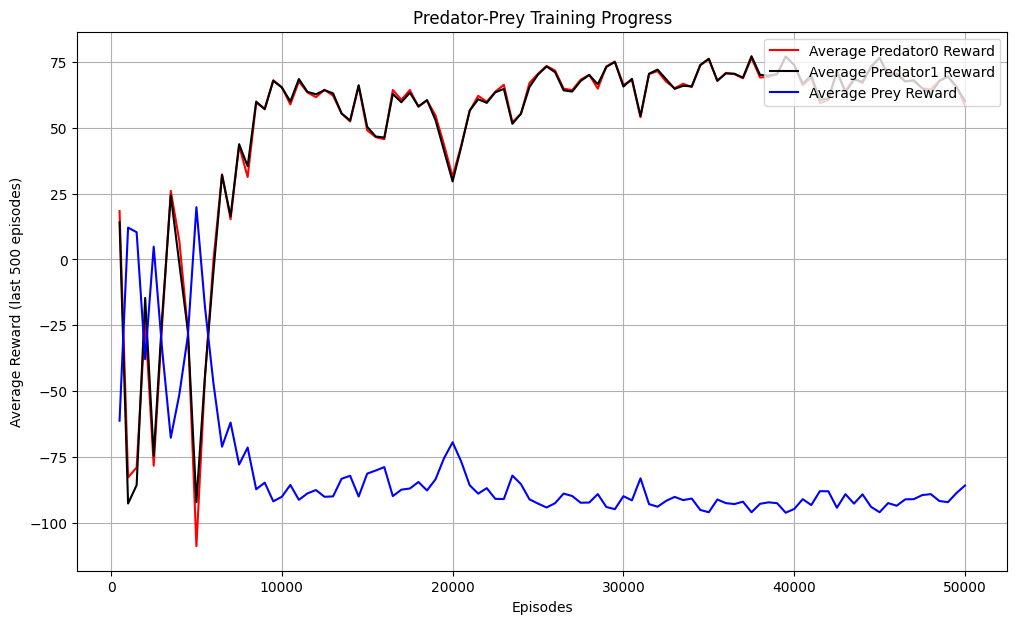

In [ ]:
#Plot episode training progress between prey and predator agents
plt.figure(figsize=(12,7))
episodes = range(500,NUM_EPISODES+1,500)
plt.plot(episodes,avg_pred0_reward_list,label='Average Predator0 Reward',color='red')
plt.plot(episodes,avg_pred1_reward_list,label='Average Predator1 Reward',color='black')
plt.plot(episodes,avg_prey_reward_list,label='Average Prey Reward',color='blue')
plt.title('Predator-Prey Training Progress')
plt.xlabel('Episodes')
plt.ylabel('Average Reward (last 500 episodes)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

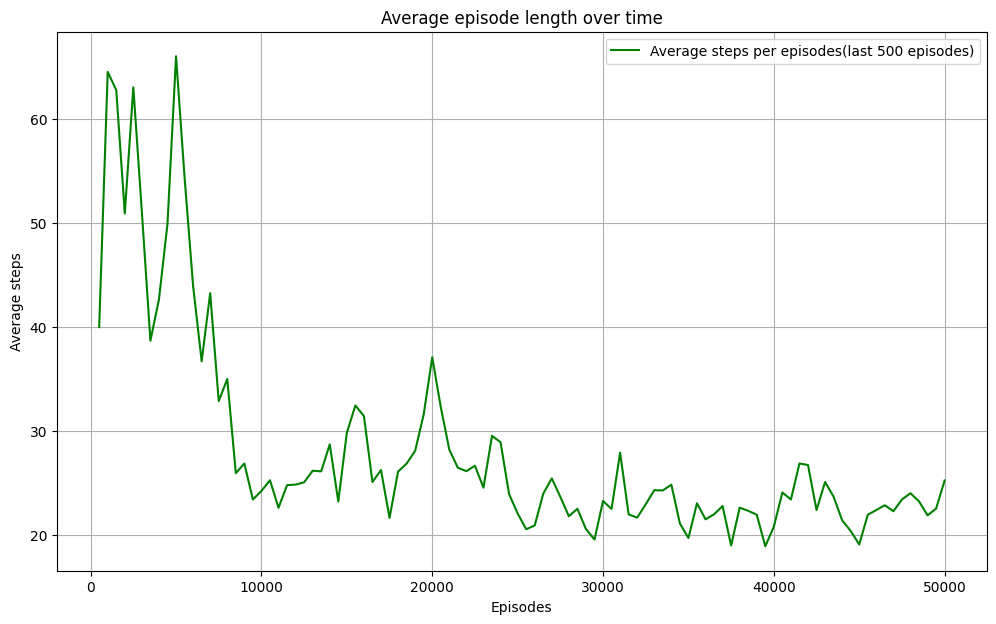

In [ ]:
#Plot average steps taken each 500 episodes
plt.figure(figsize=(12,7))
episodes = range(500,NUM_EPISODES+1,500)
plt.plot(episodes,avg_step_list,label='Average steps per episodes(last 500 episodes)',color='green')
plt.title('Average episode length over time')
plt.xlabel('Episodes')
plt.ylabel('Average steps')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!zip -r /content/project_files.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.09.19/ (stored 0%)
  adding: content/.config/logs/2025.09.19/13.39.59.525129.log (deflated 92%)
  adding: content/.config/logs/2025.09.19/13.40.42.120946.log (deflated 56%)
  adding: content/.config/logs/2025.09.19/13.40.32.438351.log (deflated 58%)
  adding: content/.config/logs/2025.09.19/13.40.41.341666.log (deflated 57%)
  adding: content/.config/logs/2025.09.19/13.40.30.940050.log (deflated 87%)
  adding: content/.config/logs/2025.09.19/13.40.21.959342.log (deflated 58%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (store